# Task 2

In [213]:
import corruptions as c
import matplotlib.pyplot as plt
import torchvision
import torch
import functools
from IPython import display
from collections.abc import Callable
from typing import Any
%matplotlib inline


# Constants 
epochs = 10

# functions to display a image, IPython.display images are two small
def show(x):
    plt.imshow(x, cmap='gray_r')
    plt.axis("off")
    plt.show()

# composes functions, from outer to inner
def compose(*functions):
    return functools.reduce(lambda f, g: lambda x: f(g(x)), functions, lambda x: x)

unsqueeze0 = functools.partial(torch.unsqueeze, dim=0)
squeeze0 = functools.partial(torch.squeeze, dim=0)

to_pil_image = torchvision.transforms.ToPILImage()
show_tensor = compose(show, squeeze0)


In [214]:
test_set = torchvision.datasets.MNIST("./data/", train=False, download=True)

all_corruptions:dict[str, Callable[[Any], Any]] = {}
for co in c.CORRUPTIONS:
    all_corruptions[co] = compose(unsqueeze0, torch.from_numpy, getattr(c, co))

identity


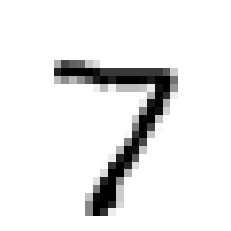

shot_noise


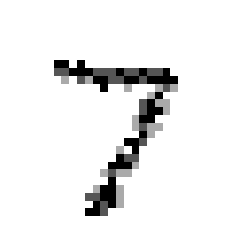

impulse_noise


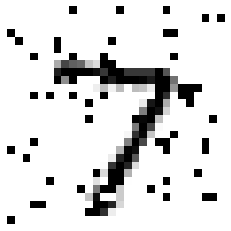

glass_blur


/home/paul/PycharmProjects/trustworthy_machine_learning/exercise_6/corruptions.py:269: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = np.uint8(gaussian(np.array(x) / 255., sigma=c[0], multichannel=True) * 255)
/home/paul/PycharmProjects/trustworthy_machine_learning/exercise_6/corruptions.py:281: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = np.clip(gaussian(x / 255., sigma=c[0], multichannel=True), 0, 1) * 255


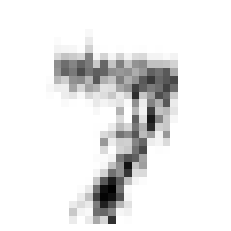

motion_blur


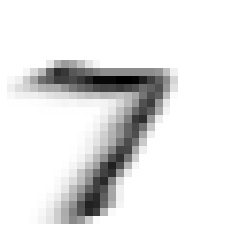

shear


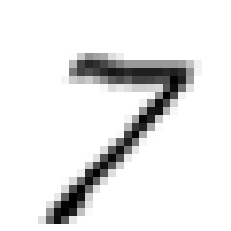

scale


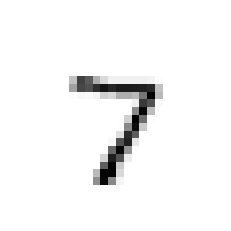

rotate


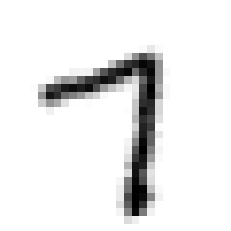

brightness


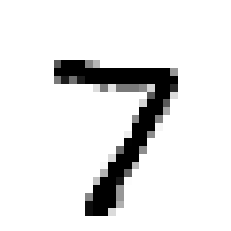

translate


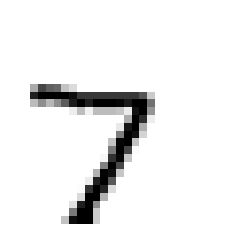

stripe


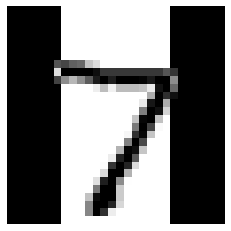

fog


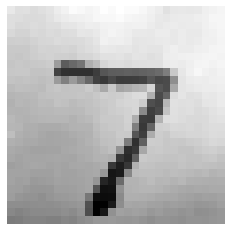

spatter


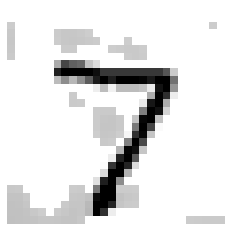

dotted_line


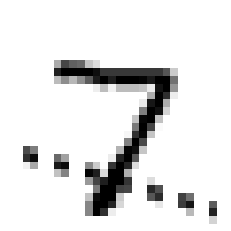

zigzag


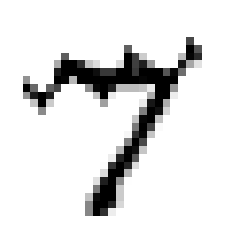

canny_edges


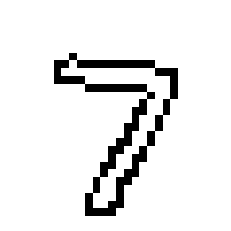

In [215]:
# 
image, label = test_set[0]

for cn, corr in all_corruptions.items():
    c_image = corr(image)
    print(cn)
    show_tensor(c_image)

# Part b

Train two modells on a clean Dataset and see how they evaluate the corruptions

In [216]:
# Create corrupted Dataloaders
from torch.utils.data import DataLoader

test_data_loaders:dict[str, torch.utils.data.DataLoader] = {}
batch_size = 100

# i apply the identity corruption as a transformation, because ToTensor() scales to 0..1 and the corruptions stay between 0..255
train_set = torchvision.datasets.MNIST(
    root="./data/", 
    train=True,
    download=True,
    transform=torchvision.transforms.Lambda(all_corruptions["identity"])
)

train_dataloader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
for cn, corruption in all_corruptions.items():
    ds = torchvision.datasets.MNIST(
        "./data/", 
        train=False,
        download=True, 
        transform=torchvision.transforms.Lambda(corruption)
    )
    test_data_loaders[cn] = DataLoader(ds, shuffle=False, batch_size=batch_size)
    
# This takes years so fuck it
test_data_loaders.pop("glass_blur")

In [217]:
# Define our two modells, CnnFlatten and CnnGlobalPooling

# I just took the BadNet architecture from the previous exercise
import pytorch_lightning as pl
from torch import nn

class CnnFlatten(pl.LightningModule):

    def __init__(self):
        super(CnnFlatten, self).__init__()        
        self.conv1 = torch.nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
            ),                              
            nn.ReLU(),                      
            nn.AvgPool2d(kernel_size=(2, 2), stride=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, 
                kernel_size=5, 
                stride=1),     
            nn.ReLU(),                      
            nn.AvgPool2d(kernel_size=(2, 2), stride=2),                
        )
        self.f1 = nn.Sequential(
            nn.Linear(in_features=(32 * 4 * 4), out_features=512),
            nn.ReLU(),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Sequential(
            nn.Linear(in_features=512, out_features=10),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)        
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        x = self.f1(x)
        output = self.out(x)
        return output

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        out = self.forward(x)

        loss = nn.functional.cross_entropy(out, y)
        self.log("train_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        # this is the test loop
        x, y = batch
        out = self.forward(x)
        test_loss = nn.functional.cross_entropy(out, y)
        self.log("test_loss", test_loss)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.forward(x)
        validiation_loss = nn.functional.cross_entropy(out, y)
        self.log("validation_loss", validiation_loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

class CnnGlobalPooling(pl.LightningModule):

    def __init__(self):
        super(CnnGlobalPooling, self).__init__()        
        self.conv1 = torch.nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
            ),                              
            nn.ReLU(),                      
            nn.AvgPool2d(kernel_size=(2, 2), stride=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, 
                kernel_size=5, 
                stride=1),     
            nn.ReLU(),                      
            nn.AvgPool2d(kernel_size=(2, 2), stride=2),                
        )
        self.pool = nn.AvgPool2d(kernel_size=(4, 4), stride=1)
        # fully connected layer, output 10 classes
        self.out = nn.Sequential(
            nn.Linear(in_features=32, out_features=10),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)        
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = self.pool(x)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        out = self.forward(x)

        loss = nn.functional.cross_entropy(out, y)
        self.log("train_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        # this is the test loop
        x, y = batch
        out = self.forward(x)
        test_loss = nn.functional.cross_entropy(out, y)
        self.log("test_loss", test_loss)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.forward(x)
        validiation_loss = nn.functional.cross_entropy(out, y)
        self.log("validation_loss", validiation_loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [218]:
cnn_pool = CnnGlobalPooling()
cnn_flatten = CnnFlatten()

t1 = pl.Trainer(max_epochs=epochs)
t2 = pl.Trainer(max_epochs=epochs)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [219]:
t1.fit(model=cnn_flatten, train_dataloaders=train_dataloader)
t2.fit(model=cnn_pool, train_dataloaders=train_dataloader)


  | Name  | Type       | Params
-------------------------------------
0 | conv1 | Sequential | 416   
1 | conv2 | Sequential | 12.8 K
2 | f1    | Sequential | 262 K 
3 | out   | Sequential | 5.1 K 
-------------------------------------
281 K     Trainable params
0         Non-trainable params
281 K     Total params
1.124     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]


  | Name  | Type       | Params
-------------------------------------
0 | conv1 | Sequential | 416   
1 | conv2 | Sequential | 12.8 K
2 | pool  | AvgPool2d  | 0     
3 | out   | Sequential | 330   
-------------------------------------
13.6 K    Trainable params
0         Non-trainable params
13.6 K    Total params
0.054     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [220]:
def test_all(model, trainer, data_loaders):
    for n, cd in data_loaders.items():
        print(f"evaluation corruption: {n} on model: {type(model)}")
        trainer.test(model=cnn_flatten, dataloaders=cd)

test_all(cnn_flatten, t1, test_data_loaders)
test_all(cnn_pool, t2, test_data_loaders)

evaluation corruption: identity on model: <class '__main__.CnnFlatten'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.4896459579467773
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: shot_noise on model: <class '__main__.CnnFlatten'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.4970918893814087
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: impulse_noise on model: <class '__main__.CnnFlatten'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.6247295141220093
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: motion_blur on model: <class '__main__.CnnFlatten'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.5985994338989258
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: shear on model: <class '__main__.CnnFlatten'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.5286617279052734
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: scale on model: <class '__main__.CnnFlatten'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.6649261713027954
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: rotate on model: <class '__main__.CnnFlatten'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.5896209478378296
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: brightness on model: <class '__main__.CnnFlatten'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.6650171279907227
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: translate on model: <class '__main__.CnnFlatten'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           2.1161577701568604
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: stripe on model: <class '__main__.CnnFlatten'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.630574107170105
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: fog on model: <class '__main__.CnnFlatten'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.8838205337524414
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: spatter on model: <class '__main__.CnnFlatten'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.5086954832077026
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: dotted_line on model: <class '__main__.CnnFlatten'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.5207862854003906
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: zigzag on model: <class '__main__.CnnFlatten'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.5776723623275757
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: canny_edges on model: <class '__main__.CnnFlatten'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.8159154653549194
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: identity on model: <class '__main__.CnnGlobalPooling'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.4896459579467773
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: shot_noise on model: <class '__main__.CnnGlobalPooling'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.4967434406280518
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: impulse_noise on model: <class '__main__.CnnGlobalPooling'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.6226743459701538
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: motion_blur on model: <class '__main__.CnnGlobalPooling'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.6004382371902466
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: shear on model: <class '__main__.CnnGlobalPooling'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.5292561054229736
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: scale on model: <class '__main__.CnnGlobalPooling'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.6649261713027954
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: rotate on model: <class '__main__.CnnGlobalPooling'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.587993860244751
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: brightness on model: <class '__main__.CnnGlobalPooling'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.6650171279907227
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: translate on model: <class '__main__.CnnGlobalPooling'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            2.108613967895508
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: stripe on model: <class '__main__.CnnGlobalPooling'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.630574107170105
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: fog on model: <class '__main__.CnnGlobalPooling'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.8815171718597412
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: spatter on model: <class '__main__.CnnGlobalPooling'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.507866382598877
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: dotted_line on model: <class '__main__.CnnGlobalPooling'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.5232985019683838
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: zigzag on model: <class '__main__.CnnGlobalPooling'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.5757083892822266
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: canny_edges on model: <class '__main__.CnnGlobalPooling'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.8159154653549194
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


# Part C 

Train a cnn on a corrupted Dataset and repeat the tests from before

In [221]:
# I picked the translate corruption, because it had the biggest error while testing
corruption = all_corruptions["translate"]
corrupted_train_set = torchvision.datasets.MNIST(
    root="./data/",
    train=True,
    download=True, 
    transform=torchvision.transforms.Lambda(corruption)
)
corrupted_data_loader = DataLoader(corrupted_train_set, batch_size=batch_size, shuffle=True)

In [222]:
cnn = CnnFlatten()
trainer = pl.Trainer(max_epochs=epochs)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [223]:
trainer.fit(model=cnn, train_dataloaders=corrupted_data_loader)


  | Name  | Type       | Params
-------------------------------------
0 | conv1 | Sequential | 416   
1 | conv2 | Sequential | 12.8 K
2 | f1    | Sequential | 262 K 
3 | out   | Sequential | 5.1 K 
-------------------------------------
281 K     Trainable params
0         Non-trainable params
281 K     Total params
1.124     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [224]:
test_all(cnn, trainer, test_data_loaders)

evaluation corruption: identity on model: <class '__main__.CnnFlatten'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.4896459579467773
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: shot_noise on model: <class '__main__.CnnFlatten'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.4989686012268066
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: impulse_noise on model: <class '__main__.CnnFlatten'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.6240789890289307
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: motion_blur on model: <class '__main__.CnnFlatten'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.597143530845642
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: shear on model: <class '__main__.CnnFlatten'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.527769684791565
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: scale on model: <class '__main__.CnnFlatten'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.6649261713027954
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: rotate on model: <class '__main__.CnnFlatten'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.5902730226516724
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: brightness on model: <class '__main__.CnnFlatten'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.6650171279907227
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: translate on model: <class '__main__.CnnFlatten'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            2.104222297668457
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: stripe on model: <class '__main__.CnnFlatten'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.630574107170105
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: fog on model: <class '__main__.CnnFlatten'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.880719542503357
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: spatter on model: <class '__main__.CnnFlatten'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.5063772201538086
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: dotted_line on model: <class '__main__.CnnFlatten'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.5220024585723877
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: zigzag on model: <class '__main__.CnnFlatten'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.5761802196502686
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
evaluation corruption: canny_edges on model: <class '__main__.CnnFlatten'>


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.8159154653549194
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
